# General Imports and Setup

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [3]:
import os
import shutil
# from skimage import io, transform
from skimage import io
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [4]:
# ROOT_DIR = '/home/elandg/ml/Pawpularity'
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/home/elandg/ml/Pawpularity


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# Competition Download

Uncomment and run these code cells to load the dataset.

In [119]:
# ! pip uninstall -y kaggle # run if error '429' when trying to download competition

In [120]:
# % cd /content/drive/MyDrive/'Colab Notebooks'/Pawpularity
# ! mkdir ~/.kaggle
# ! cp ../kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! pip install -q kaggle --upgrade
# ! kaggle -v
# ! kaggle competitions download -c petfinder-pawpularity-score -o
# ! ls

In [121]:
# ! kaggle competitions download -h

In [122]:
# ! unzip -q -o petfinder-pawpularity-score.zip

<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
        the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



### TODO:
* Tensorize
* Organize transforms
* Organize weight initializations
* Base ResNet to identify what pets are in consideration
* Organize gradient settings

# Create Dataset

In [6]:
class PawpularityDataset(Dataset):
    """Pawpularity dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        # print(self.df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
            return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # pd.loc can retrieve multiple rows/columns
        metadata = torch.tensor(self.df.loc[idx, 'Subject Focus':'Blur'])

        # pd.at is faster than pd.loc but only works for single values
        img_name = os.path.join(self.root_dir,
                                self.df.at[idx, 'Id'] + '.jpg')

        image = Image.fromarray(io.imread(img_name))
        score = torch.tensor(self.df.at[idx, 'Pawpularity'] - 1).long()

        sample = {'image': image, 'metadata':metadata, 'score': score}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample
    
    def get_img_sizes(self, verbose=False):
        img_sizes = []
        count = 0
        for i in range(len(self)):
            if verbose and count % 1000 == 0:
                print(count)
            img = np.array(self[i]['image'])
            if not isinstance(img, (np.ndarray)):
                img_sizes.append(img.data().cpu().numpy().shape)
            else:
                img_sizes.append(img.shape)
            count += 1
        if verbose:
            print(count)
        return img_sizes


    # def save_augmented_imgs(self, verbose=False, todo=True):
    #     if todo:
    #         print('save_augmented_imgs not implemented')
    #         return
    #     path = os.path.join(self.root_dir, 'augmented')
    #     if not os.path.exists(path):
    #         os.makedirs(path)
    #     else:
    #         shutil.rmtree(path)                     # Removes all the subdirectories!
    #         os.makedirs(path)

    #     for idx, sample in enumerate(self):
    #         if verbose and idx % 1000 == 0:
    #             print(idx)
    #         img_path = os.path.join(path, self.df.at[idx, 'Id'] + '.jpg')
    #         if torch.is_tensor(sample['image']):
    #             io.imsave(img_path, transforms.functional.to_pil_image(sample['image']))
    #         else:
    #             io.imsave(img_path, sample['image'])
    #     if verbose:
    #         print(len(self))
            
# Parameters for "Data Analysis"
csv_file = os.path.join(ROOT_DIR, 'train.csv')
images = os.path.join(ROOT_DIR, 'train')
# transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize(IMG_SIZE)
# ])
transform = None
dataset = PawpularityDataset(csv_file, images, transform=transform)

# Data Analysis

In [134]:
batch_size = 16

def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for sample in dataloader:
        data = sample['image']
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# mean, std = get_mean_and_std(dataloader)
# print(f'mean: {mean}, std: {std}') # mean: [0.5188, 0.4840, 0.4462] std: [0.2681, 0.2639, 0.2659]

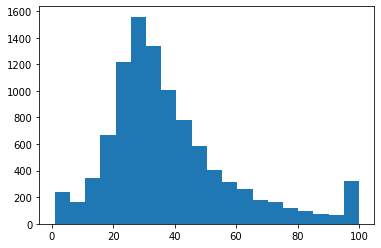

In [124]:
scores = dataset.df['Pawpularity']
_ = plt.hist(scores, bins=20)

In [125]:
print(min(scores), max(scores))

1 100


In [126]:
img_sizes = dataset.get_img_sizes(verbose=True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
9912


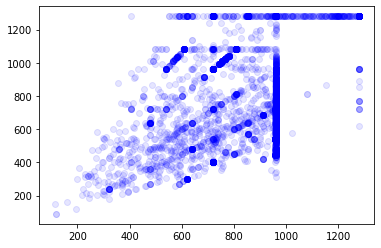

In [127]:
img_sizes = np.array(img_sizes)
plt.scatter(img_sizes[:,0], img_sizes[:,1], color='blue', alpha=.1)

In [128]:
print(np.amax(img_sizes[:,0]))
print(np.amax(img_sizes[:,1]))
# x = np.array((
#     (1, 2, 1),
#     (2, 2, 1),
#     (2, 2, 1),
#     (2, 3, 1)
# ))
vals, counts = np.unique(img_sizes, return_counts=True, axis=0) # returns unique H x W pairings and counts for each pairing
# print(vals, len(counts))
top_n = 5
print(np.sort(-1 * counts)[:top_n])
index = np.argsort(-1 * counts)[:top_n] # sorts indices by highest to lowest counts and returns top 5 highest
print(vals[index])

1280
1280
[-3527  -802  -619  -302  -272]
[[ 960  720    3]
 [ 960 1280    3]
 [ 960  540    3]
 [1280 1280    3]
 [ 960  960    3]]


[1.77777778 0.75       1.33333333 ... 1.28735632 1.33333333 1.77777778]


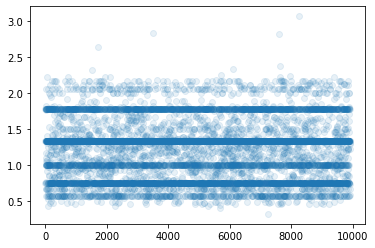

In [129]:
print(img_sizes[:,0] / img_sizes[:,1])
# print dist of aspect ratios
plt.scatter(range(9912), img_sizes[:,0] / img_sizes[:,1], alpha=.1)

# Design Model

In [15]:
import re

from torchvision.models import inception_v3, Inception_V3_Weights, \
                                resnet50, ResNet50_Weights, \
                                alexnet, AlexNet_Weights, \
                                vgg19_bn, VGG11_BN_Weights, \
                                densenet201, DenseNet201_Weights, \
                                efficientnet_b7, EfficientNet_B7_Weights, \
                                efficientnet_v2_l, EfficientNet_V2_L_Weights

# Initialize weights to small random values (speeds up training)
# Should not use if loading pretrained weights
def initialize_weights(model):
    for module in model.modules():
        # print(module)
        if isinstance(module, nn.Conv2d):
            nn.init.uniform_(module.weight.data)
            if module.bias is not None:
                nn.init.constant_(module.bias.data, 0.0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.uniform_(module.weight.data)
            nn.init.uniform_(module.bias.data)
        elif isinstance(module, nn.Linear):
            nn.init.uniform_(module.weight.data)
            if module.bias is not None:
                nn.init.constant_(module.bias.data, 0)

# model requires grad by default
# if we dont have weights aka FE is false
#     all layers require grad
# else we do have weights aka FE is true
#     all layers except last dont require grad

# Finetuning is taking a pretrained model and training more
# Feature extracting is only training final layer
# Only training final layer if feature_extracting=True
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

class MetaNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(MetaNet, self).__init__()
        self.name = 'metanet'
        self.backbone = backbone
        self.fc1 = nn.Linear(num_classes + 12, 1)
        
    def forward(self, image, data):
        if self.backbone.name == 'inception':
            x1 = self.backbone(image).logits
        else:
            x1 = self.backbone(image)
        x2 = data
        
        x = torch.cat((x1, x2), dim=1)
        x = self.fc1(x)
        return x

def initialize_model(model_name, metadata, pretrained_weights=None):
        # Initialize these variables which will be set in this if statement. Each of these
        # variables is model specific.
        model_ft = None
        transform = None
        input_size = 0

        if metadata:
            num_classes = 10 # hyperparameter
        else:
            num_classes = 1

        if model_name == "resnet":
            """ Resnet18
            """
            model_ft = models.resnet50(weights=pretrained_weights)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, num_classes)
            input_size = 232

        elif model_name == "alexnet":
            """ Alexnet
            """
            model_ft = models.alexnet(weights=pretrained_weights)
            num_ftrs = model_ft.classifier[6].in_features
            model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
            input_size = 224

        elif model_name == "vgg":
            """ VGG11_bn
            """
            model_ft = models.vgg11_bn(weights=pretrained_weights)
            num_ftrs = model_ft.classifier[6].in_features
            model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
            input_size = 224

        elif model_name == "squeezenet":
            """ Squeezenet
            """
            model_ft = models.squeezenet1_0(weights=pretrained_weights)
            model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
            model_ft.num_classes = num_classes
            input_size = 224

        elif model_name == "densenet":
            """ Densenet
            """
            model_ft = models.densenet121(weights=pretrained_weights)
            num_ftrs = model_ft.classifier.in_features
            model_ft.classifier = nn.Linear(num_ftrs, num_classes)
            input_size = 224

        elif model_name == "inception":
            """ Inception v3
            Be careful, expects (299,299) sized images and has auxiliary output
            """
            model_ft = models.inception_v3(weights=pretrained_weights)
            # Handle the auxilary net
            num_ftrs = model_ft.AuxLogits.fc.in_features
            model_ft.AuxLogits.fc = nn.Linear(num_ftrs, 1)
            # Handle the primary net
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, num_classes)
            input_size = 299
        
        # Too large
        elif model_name == "convnext":
            """ ConvNeXt
            """
            model_ft = models.convnext_large(weights=pretrained_weights)
            num_ftrs = model_ft.classifier[2].in_features
            model_ft.classifier[2] = nn.Linear(num_ftrs, num_classes)
            input_size = 232

        # Too large
        elif model_name == "efficient_b7":
            """ EfficientNet
            """
            model_ft = models.efficientnet_b7(weights=pretrained_weights)
            num_ftrs = model_ft.classifier[1].in_features
            model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
            input_size = 600

        elif model_name == "efficient_V2_L":
            """ EfficientNet
            """
            model_ft = models.efficientnet_b7(weights=pretrained_weights)
            num_ftrs = model_ft.classifier[1].in_features
            model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
            input_size = 480

        else:
            print("Invalid model name, exiting...")
            exit()

        
        # with open('model.txt', 'w') as f:
        #     print(model_ft, file=f);

        if metadata:
            model_ft.name = model_name
            net = MetaNet(model_ft, num_classes)

        # Can pass in pretrained model weights and transforms or start fresh with only model architecture
        if pretrained_weights is not None:
            # set_parameter_requires_grad(model_ft)
            transform = pretrained_weights.transforms()
            # https://stackoverflow.com/questions/3075130/what-is-the-difference-between-and-regular-expressions
            # https://stackoverflow.com/questions/6109882/regex-match-all-characters-between-two-strings
            input_size = int(re.search('(?<=resize_size=)([^Z]*)(?=,)|(?<=resize_size=)([^Z]*)(?=\))', str(pretrained_weights.transforms)).group(0))
            # input_size = int(re.search('(?<=resize_size=)([^Z]*)(?=\n)', str(transform)).group(0)) # struggling to recognize characters in str
        else:
            initialize_weights(model_ft)
            transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize(IMG_SIZE),
                            transforms.Normalize(
                                mean=[0.5188, 0.4840, 0.4462],
                                std=[0.2681, 0.2639, 0.2659]
                            )
                        ])

        return net, input_size, transform

model_dicts = [
    {'name': 'resnet', 'weights': ResNet50_Weights.IMAGENET1K_V2},
    {'name': 'alexnet', 'weights': AlexNet_Weights.IMAGENET1K_V1},
    {'name': 'vgg', 'weights': VGG11_BN_Weights.IMAGENET1K_V1},
    {'name': 'squeezenet', 'weights': None},
    {'name': 'densenet', 'weights': DenseNet201_Weights.IMAGENET1K_V1},
    {'name': 'inception', 'weights': Inception_V3_Weights.IMAGENET1K_V1},
    {'name': 'convnext', 'weights': None},
    {'name': 'efficient_b7', 'weights': EfficientNet_B7_Weights.IMAGENET1K_V1},
    {'name': 'efficient_V2_L', 'weights': EfficientNet_V2_L_Weights.IMAGENET1K_V1},
]

model_dict = model_dicts[0]
model_name = model_dict['name']
# pretrained_weights = None
pretrained_weights = model_dict['weights']

metadata = True

# Initialize the model for this run
net, img_size, transform = initialize_model(model_name, metadata, pretrained_weights=pretrained_weights)
IMG_SIZE = (img_size, img_size)

# Print the model we just instantiated
with open('model.txt', 'w') as f:
    print(net, file=f);

net.to(device);

# calc new rgb mean and std with new image size?
# be able to have a shortcut button to run selected cell cluster that is always on the screen. similar to run above and cell/below

In [16]:
# N must be > 1 or else it breaks when running batch norm layer
input_shape = ((2, 3) + IMG_SIZE)
input_imgs = torch.zeros(input_shape)
input_metadata = torch.zeros((2, 12))
output = net(input_imgs.to(device), input_metadata.to(device))
print(output)

tensor([[-0.2322],
        [-0.2322]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [17]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t)
print(r)
print(a)
print(f)
torch.cuda.mem_get_info()

4294836224
335544320
284541440
51002880


(2680986011, 4294836224)

In [18]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

criterion = RMSELoss()
# criterion = nn.MSELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss()

# confusing but works
with open('weights.txt', 'w') as f:
    params_to_update = net.parameters()
    f.write("Params to learn: \n")
    if pretrained_weights is not None:
        params_to_update = []
        for name,param in net.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                f.write(f'\t {name}\n')
    else:
        for name,param in net.named_parameters():
            if param.requires_grad == True:
                f.write(f'\t {name}\n')


# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.8, dampening=0, weight_decay=0.00005)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Prepare Data

In [20]:
# # Run to compute optimal number of workers for system
# from time import time
# import multiprocessing as mp
# opt_num_workers = 0
# min_time = float('inf')
# for num_workers in range(2, mp.cpu_count(), 2):  
#     tr_loader = DataLoader(trainset, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=False)
#     start = time()
#     for epoch in range(1, 3):
#         for i, data in enumerate(tr_loader, 0):
#             pass
#     end = time()
#     timespan = end - start
#     if timespan < min_time:
#         opt_num_workers = num_workers
#         min_time = timespan
#     print("Finish with:{} second, num_workers={}".format(end - start, num_workers))
# print(opt_num_workers)

opt_num_workers = 4

batch_size = 16

dataset = PawpularityDataset(csv_file, images, transform=transform)

# 9912 samples total
trainset, valset, testset = torch.utils.data.random_split(dataset, [6912, 2000, 1000])

tr_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=opt_num_workers)

val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=opt_num_workers)

te_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=opt_num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


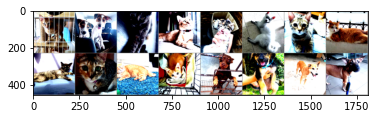

 14  99  32  49  37  99  33  67  28  28  43  54  61   6  20  40


In [21]:
# function to show an image - seems like images are not restored properly
def imshow(img):
    # print(img.size()) # 8 x 4 grid casuses shape of 1810 x 906
    img = img / 2 + 0.5         # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # print(img.size())
    # stds = [0.2681, 0.2639, 0.2659]
    # means = [0.5188, 0.4840, 0.4462]
    # img = np.dstack((img[i] * stds[i] + means[i] for i in range(3)))
    # img = img * [0.2681, 0.2639, 0.2659] + [0.5188, 0.4840, 0.4462]
    plt.show()


# get some random training images
dataiter = iter(te_loader)
print(dataiter)
# Keeps breaking after training?
batch = dataiter.next()
# print(batch['image'].size())

# show images
imshow(torchvision.utils.make_grid(batch['image']))
classes = [i for i in range(100)]
# print(classes)

# print labels
print(' '.join('%3s' % classes[batch['score'][j]] for j in range(batch_size))) # Use classes[...] to remove tensor notation

# Train Model

Training for resnet_1
Finished Training


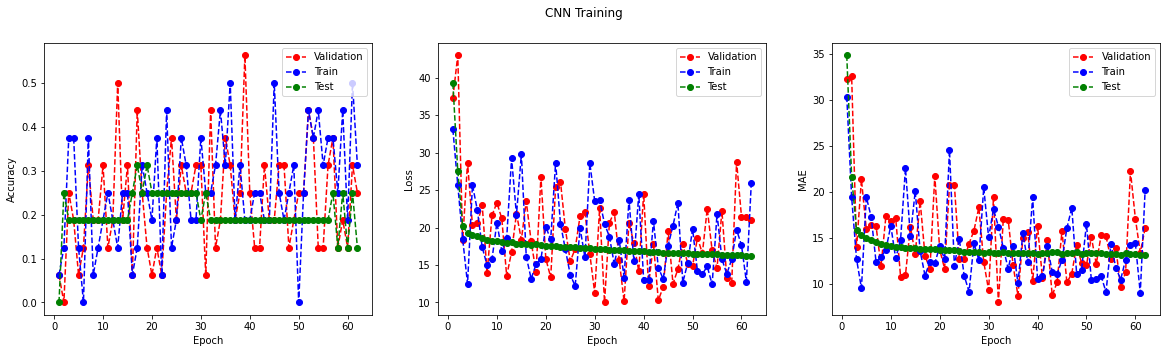

In [141]:
# from sklearn.metrics import mean_absolute_error
mean_absolute_error = nn.L1Loss()

# TODO: if path exists, print the stats to a text file all at once at the end
def log_training(epoch, stats, path=None):
    """Print the train, validation, test accuracy/loss/auroc.

    Each epoch in `stats` should have order
        [val_acc, val_loss, val_auc, train_acc, ...]
    Test accuracy is optional and will only be logged if stats is length 9.
    """
    include_train = len(stats[-1]) / 3 == 3
    splits = ["Validation", "Train", "Test"]
    metrics = ["Accuracy", "Loss", "MAE"]
    if path is not None:
        with open(path, 'a') as f:
            print("Epoch {}".format(epoch), file=f)
            for j, split in enumerate(splits):
                for i, metric in enumerate(metrics):
                    idx = len(metrics) * j + i
                    if idx >= len(stats[-1]):
                        continue
                    print(f"\t{split} {metric}:{round(stats[-1][idx],4)}", file=f)
    else:
        print("Epoch {}".format(epoch))
        for j, split in enumerate(splits):
            for i, metric in enumerate(metrics):
                idx = len(metrics) * j + i
                if idx >= len(stats[-1]):
                    continue
                print(f"\t{split} {metric}:{round(stats[-1][idx],4)}")

def make_training_plot(name="CNN Training"):
    """Set up an interactive matplotlib graph to log metrics during training."""
    plt.ion()
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(name)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("MAE")

    return axes

def update_training_plot(axes, epoch, stats):
    """Update the training plot with a new data point for loss and accuracy."""
    splits = ["Validation", "Train", "Test"]
    metrics = ["Accuracy", "Loss", "MAE"]
    colors = ["r", "b", "g"]
    for i, metric in enumerate(metrics):
        for j, split in enumerate(splits):
            idx = len(metrics) * j + i
            if idx >= len(stats[-1]):
                continue
            # __import__('pdb').set_trace()
            axes[i].plot(
                range(epoch - len(stats) + 1, epoch + 1),
                [stat[idx] for stat in stats],
                linestyle="--",
                marker="o",
                color=colors[j],
            )
        axes[i].legend(splits[: int(len(stats[-1]) / len(metrics))])
    plt.pause(0.00001)

def print_plots(epoch, stats, name="CNN Training", path=None):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(name)
    # axes[0].set_xlabel("Epoch")
    # axes[0].set_ylabel("Accuracy")
    # axes[1].set_xlabel("Epoch")
    # axes[1].set_ylabel("Loss")
    # axes[2].set_xlabel("Epoch")
    # axes[2].set_ylabel("AUROC")

    splits = ["Validation", "Train", "Test"]
    metrics = ["Accuracy", "Loss", "MAE"]
    colors = ["r", "b", "g"]
    for i, metric in enumerate(metrics):
        for j, split in enumerate(splits):
            idx = len(metrics) * j + i
            if idx >= len(stats[-1]):
                continue
            # __import__('pdb').set_trace()
            axes[i].plot(
                range(epoch - len(stats) + 1, epoch + 1),
                [stat[idx] for stat in stats],
                linestyle="--",
                marker="o",
                color=colors[j],
            )
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metrics[i])
        axes[i].legend(splits[: int(len(stats[-1]) / len(metrics))])
    if path:
        plt.savefig(path)
    plt.pause(0.00001)

def predictions(model_name, output):
    # print(logits.size())
    if model_name == 'inception':
        return output.logits.T[0].float()
    else:
        return output.T[0].float()

def train_epoch(data_loader, model, criterion, optimizer):
    for i, sample in enumerate(data_loader, 0):
        # inputs, labels = data
        inputs = sample['image'].to(device)
        metadata = sample['metadata'].to(device)
        labels = sample['score'].to(device)
        # if i == 0:
        #     print(sample['metadata'])

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs, metadata)

        predicted = predictions(model.name, outputs)
        # print(type(outputs[0]))
        loss = criterion(predicted.float(), labels.float())
        # print(type(loss))
        loss.backward()
        optimizer.step()

def evaluate_epoch(tr_loader, val_loader, te_loader, model, criterion, epoch, stats=[], include_test=False, path=None):
    def _get_metrics(loader):
        y_true, y_pred, y_score = [], [], []
        correct, total = 0, 0
        running_loss = []
        for sample in loader:
            with torch.no_grad():
                # inputs = sample['image']
                # labels = sample['score']
                inputs = sample['image'].to(device)
                metadata = sample['metadata'].to(device)
                # print(metadata)
                labels = sample['score']
                outputs = model(inputs, metadata)
                # print(output)
                # output = model(inputs).logits.T[0].float()
                # print(output)
                predicted = predictions(model.name, outputs)
                
                y_true.append(labels)
                y_pred.append(predicted)
                y_score.append(outputs)
                # y_score.append(F.softmax(output, dim=1))
                # print(f'Predicted: {y_pred}, {len(y_pred[0])}')
                # print(f'Labels: {y_true}, {len(y_true[0])}')
                # print(f'Score: {y_score}, {y_score[0].size()}')
                total += labels.size(0)
                correct += (torch.abs(predicted - labels.to(device)) < 5).sum().item()
                # correct += (predicted == labels.to(device)).sum().item()
                running_loss.append(criterion(predicted, labels.to(device)).item())
                y_true = torch.cat(y_true)
                y_pred = torch.cat(y_pred)
                y_score = torch.cat(y_score)
                loss = torch.mean(torch.tensor(running_loss)).item()
                # print(loss)
                acc = correct / total
                mae = mean_absolute_error(predicted, labels.to(device)).item()
                # auroc = metrics.roc_auc_score(y_true, y_score)
                # auroc = metrics.roc_auc_score(y_true.cpu(), y_score.cpu(), multi_class="ovo", labels= [i for i in range(100)])
                # return acc, loss, auroc
                return acc, loss, mae

    train_acc, train_loss, train_auc = _get_metrics(tr_loader)
    # print(f'Train Acc: {train_acc}, Loss: {train_loss}, AUC: {train_auc}')
    val_acc, val_loss, val_auc = _get_metrics(val_loader)
    # print(f'Val Acc: {val_acc}, Loss: {val_loss}, AUC: {val_auc}')

    stats_at_epoch = [
        val_acc,
        val_loss,
        val_auc,
        train_acc,
        train_loss,
        train_auc,
    ]
    if include_test:
        stats_at_epoch += list(_get_metrics(te_loader))

    stats.append(stats_at_epoch)
    # print(stats)
    log_training(epoch, stats, path)
    
    # if update_plot:
    #     update_training_plot(axes, epoch, stats)
    
    return stats

save_name = net.backbone.name + '_1'
MODEL_PATH = os.path.join(ROOT_DIR, save_name + '.pt')
MODEL_STATS_PATH = os.path.join(ROOT_DIR, save_name + '.txt')
MODEL_GRAPHS_PATH = os.path.join(ROOT_DIR, save_name + '.jpg')

print(f'Training for {save_name}')

epoch = 0
max_epochs = 150
patience = 30
curr_patience_count = 0
stats = []
stats = evaluate_epoch(tr_loader, val_loader, te_loader, net, criterion, epoch, include_test=True, path=MODEL_STATS_PATH)
epoch += 1
global_min_loss = stats[0][1] # starting val loss

# for epoch in range(num_epochs):
while epoch < max_epochs and curr_patience_count < patience:
    running_loss = []
    train_epoch(tr_loader, net, criterion, optimizer)

    # evaluate epoch
    stats = evaluate_epoch(tr_loader, val_loader, te_loader, net, criterion, epoch=epoch, stats=stats, include_test=True, path=MODEL_STATS_PATH)

    if stats[-1][1] < global_min_loss:
        curr_patience_count = 0
        global_min_loss = stats[-1][1]
        torch.save(net.state_dict(), MODEL_PATH)
    else:
        curr_patience_count += 1
    
    epoch += 1

print('Finished Training')
# print(len(stats))
print_plots(epoch, stats, path=MODEL_GRAPHS_PATH)
#E Tutorial had 54% accuracyfnet
#E A good loss is below .5 but varies depending on application and dataset

# Test Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


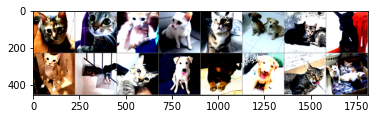

GroundTruth:     32    18    21    34    26    70    16    36    14    68    54    39    44    53     8    32


In [142]:
dataiter = iter(te_loader)
sample = dataiter.next()
images, metadata, labels = sample['image'], sample['metadata'], sample['score']

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [143]:
net.load_state_dict(torch.load('model1.pt'))
print(net.name)

RuntimeError: Error(s) in loading state_dict for MetaNet:
	Missing key(s) in state_dict: "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.downsample.0.weight", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.1.bias", "backbone.layer1.0.downsample.1.running_mean", "backbone.layer1.0.downsample.1.running_var", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.conv2.weight", "backbone.layer1.2.bn2.weight", "backbone.layer1.2.bn2.bias", "backbone.layer1.2.bn2.running_mean", "backbone.layer1.2.bn2.running_var", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.conv2.weight", "backbone.layer2.2.bn2.weight", "backbone.layer2.2.bn2.bias", "backbone.layer2.2.bn2.running_mean", "backbone.layer2.2.bn2.running_var", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.conv2.weight", "backbone.layer2.3.bn2.weight", "backbone.layer2.3.bn2.bias", "backbone.layer2.3.bn2.running_mean", "backbone.layer2.3.bn2.running_var", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.conv2.weight", "backbone.layer3.2.bn2.weight", "backbone.layer3.2.bn2.bias", "backbone.layer3.2.bn2.running_mean", "backbone.layer3.2.bn2.running_var", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.conv2.weight", "backbone.layer3.3.bn2.weight", "backbone.layer3.3.bn2.bias", "backbone.layer3.3.bn2.running_mean", "backbone.layer3.3.bn2.running_var", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.conv2.weight", "backbone.layer3.4.bn2.weight", "backbone.layer3.4.bn2.bias", "backbone.layer3.4.bn2.running_mean", "backbone.layer3.4.bn2.running_var", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.conv2.weight", "backbone.layer3.5.bn2.weight", "backbone.layer3.5.bn2.bias", "backbone.layer3.5.bn2.running_mean", "backbone.layer3.5.bn2.running_var", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.conv2.weight", "backbone.layer4.2.bn2.weight", "backbone.layer4.2.bn2.bias", "backbone.layer4.2.bn2.running_mean", "backbone.layer4.2.bn2.running_var", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "backbone.fc.weight", "backbone.fc.bias". 
	Unexpected key(s) in state_dict: "net.conv1.weight", "net.bn1.weight", "net.bn1.bias", "net.bn1.running_mean", "net.bn1.running_var", "net.bn1.num_batches_tracked", "net.layer1.0.conv1.weight", "net.layer1.0.bn1.weight", "net.layer1.0.bn1.bias", "net.layer1.0.bn1.running_mean", "net.layer1.0.bn1.running_var", "net.layer1.0.bn1.num_batches_tracked", "net.layer1.0.conv2.weight", "net.layer1.0.bn2.weight", "net.layer1.0.bn2.bias", "net.layer1.0.bn2.running_mean", "net.layer1.0.bn2.running_var", "net.layer1.0.bn2.num_batches_tracked", "net.layer1.1.conv1.weight", "net.layer1.1.bn1.weight", "net.layer1.1.bn1.bias", "net.layer1.1.bn1.running_mean", "net.layer1.1.bn1.running_var", "net.layer1.1.bn1.num_batches_tracked", "net.layer1.1.conv2.weight", "net.layer1.1.bn2.weight", "net.layer1.1.bn2.bias", "net.layer1.1.bn2.running_mean", "net.layer1.1.bn2.running_var", "net.layer1.1.bn2.num_batches_tracked", "net.layer2.0.conv1.weight", "net.layer2.0.bn1.weight", "net.layer2.0.bn1.bias", "net.layer2.0.bn1.running_mean", "net.layer2.0.bn1.running_var", "net.layer2.0.bn1.num_batches_tracked", "net.layer2.0.conv2.weight", "net.layer2.0.bn2.weight", "net.layer2.0.bn2.bias", "net.layer2.0.bn2.running_mean", "net.layer2.0.bn2.running_var", "net.layer2.0.bn2.num_batches_tracked", "net.layer2.0.downsample.0.weight", "net.layer2.0.downsample.1.weight", "net.layer2.0.downsample.1.bias", "net.layer2.0.downsample.1.running_mean", "net.layer2.0.downsample.1.running_var", "net.layer2.0.downsample.1.num_batches_tracked", "net.layer2.1.conv1.weight", "net.layer2.1.bn1.weight", "net.layer2.1.bn1.bias", "net.layer2.1.bn1.running_mean", "net.layer2.1.bn1.running_var", "net.layer2.1.bn1.num_batches_tracked", "net.layer2.1.conv2.weight", "net.layer2.1.bn2.weight", "net.layer2.1.bn2.bias", "net.layer2.1.bn2.running_mean", "net.layer2.1.bn2.running_var", "net.layer2.1.bn2.num_batches_tracked", "net.layer3.0.conv1.weight", "net.layer3.0.bn1.weight", "net.layer3.0.bn1.bias", "net.layer3.0.bn1.running_mean", "net.layer3.0.bn1.running_var", "net.layer3.0.bn1.num_batches_tracked", "net.layer3.0.conv2.weight", "net.layer3.0.bn2.weight", "net.layer3.0.bn2.bias", "net.layer3.0.bn2.running_mean", "net.layer3.0.bn2.running_var", "net.layer3.0.bn2.num_batches_tracked", "net.layer3.0.downsample.0.weight", "net.layer3.0.downsample.1.weight", "net.layer3.0.downsample.1.bias", "net.layer3.0.downsample.1.running_mean", "net.layer3.0.downsample.1.running_var", "net.layer3.0.downsample.1.num_batches_tracked", "net.layer3.1.conv1.weight", "net.layer3.1.bn1.weight", "net.layer3.1.bn1.bias", "net.layer3.1.bn1.running_mean", "net.layer3.1.bn1.running_var", "net.layer3.1.bn1.num_batches_tracked", "net.layer3.1.conv2.weight", "net.layer3.1.bn2.weight", "net.layer3.1.bn2.bias", "net.layer3.1.bn2.running_mean", "net.layer3.1.bn2.running_var", "net.layer3.1.bn2.num_batches_tracked", "net.layer4.0.conv1.weight", "net.layer4.0.bn1.weight", "net.layer4.0.bn1.bias", "net.layer4.0.bn1.running_mean", "net.layer4.0.bn1.running_var", "net.layer4.0.bn1.num_batches_tracked", "net.layer4.0.conv2.weight", "net.layer4.0.bn2.weight", "net.layer4.0.bn2.bias", "net.layer4.0.bn2.running_mean", "net.layer4.0.bn2.running_var", "net.layer4.0.bn2.num_batches_tracked", "net.layer4.0.downsample.0.weight", "net.layer4.0.downsample.1.weight", "net.layer4.0.downsample.1.bias", "net.layer4.0.downsample.1.running_mean", "net.layer4.0.downsample.1.running_var", "net.layer4.0.downsample.1.num_batches_tracked", "net.layer4.1.conv1.weight", "net.layer4.1.bn1.weight", "net.layer4.1.bn1.bias", "net.layer4.1.bn1.running_mean", "net.layer4.1.bn1.running_var", "net.layer4.1.bn1.num_batches_tracked", "net.layer4.1.conv2.weight", "net.layer4.1.bn2.weight", "net.layer4.1.bn2.bias", "net.layer4.1.bn2.running_mean", "net.layer4.1.bn2.running_var", "net.layer4.1.bn2.num_batches_tracked", "net.fc.weight", "net.fc.bias". 

In [ ]:
# run if runtime disconnects
# net = model_ft
net.load_state_dict(torch.load('model2.pt'))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
device = 'cpu'
net.to(device)
outputs = net(images.to(device), metadata.to(device))
print(outputs.cpu())

tensor([[-29.8542],
        [-37.5395],
        [-29.2656],
        [-32.1755],
        [-33.4673],
        [-22.5128],
        [-39.3521],
        [-27.3795],
        [-28.5170],
        [-26.8639],
        [-26.6919],
        [-31.2490],
        [-22.7479],
        [-27.1315],
        [-18.4034],
        [-39.6522]], grad_fn=<AddmmBackward0>)


In [ ]:
# _, predicted = torch.max(outputs, 1)
# predicted = (np.round(outputs.logits.T[0].float().detach().numpy())).astype(int)
# predicted = (np.round(outputs.T[0].float().detach().numpy())).astype(int)
predicted = predictions(net.name, outputs).int().cpu().numpy()
# print(predicted)
# print(outputs)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(batch_size)))

Predicted:    -29   -37   -29   -32   -33   -22   -39   -27   -28   -26   -26   -31   -22   -27   -18   -39


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in te_loader:
        images, labels = sample['image'], sample['score']
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        # _, preds = torch.max(outputs.data, 1)
        # preds = (np.round(outputs.logits.T[0].float().detach().numpy())).astype(int)
        preds = outputs.T[0].float()
        total += labels.size(0)
        # print(preds == labels)
        correct += (torch.abs(preds - labels) < 5).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (100 * correct / total))

TypeError: MetaNet.forward() missing 1 required positional argument: 'data'

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in te_loader:
        images, labels = data        
        outputs = net(images)        
        _, preds = outputs.logits.T[0].float()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

sum = 0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                         accuracy))

TypeError: conv2d() received an invalid combination of arguments - got (str, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
